## Guidelines

Le prime celle qui in basso, in [questa](http://localhost:8888/notebooks/charts.ipynb#Setting-Up) sezione, hanno lo scopo di scaricare e installare i pacchetti (se non già presenti) e di importare moduli e file csv.


Nel blocco di codice in cui si stampa ogni grafico, ci saranno commentate le label e le intestazioni, perché il grafico viene esportato in `.svg` nella cartella `/charts/` e viene aggiunto in una fase successiva, durante la creazione della presentazione.

## Setting Up

In [1]:
# import sys
# !{sys.executable} -m pip install seaborn

In [2]:
columns_mapping = {"Gioco": "name", "Genere (principale)": "genre", "Produzione*": "production", "Origine": "from_where", "prezzo(€)": "price_in_euro", "Vendite stimate(k)": "sales_k", "max giocatori": "max_players", "recensioni positive(%)": "reviews"}
boolean_mapping = {'TRUE': True, '': False}

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
import plotly.express as px
import joypy

import os
import glob

In [4]:
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
import matplotlib.font_manager as fm

url = 'https://github.com/google/fonts/blob/main/ofl/lato/Lato-Regular.ttf?raw=true'

response = urlopen(url)
f = NamedTemporaryFile(delete=False, suffix='.ttf')
f.write(response.read())
f.close()

fm.fontManager.addfont(f.name)
prop = fm.FontProperties(fname=f.name)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

plt.rcParams["svg.fonttype"] = 'none'

In [5]:
def fillempty_floats(df, columns):
    for column in columns:
        df[column] = df[column].replace('', 0)
        df[column] = df[column].astype('float32')
    return df

def build_chart_path(name):
    return f"charts/{name}.svg"

In [6]:
games = pd.read_csv("data/2024-games.csv", na_filter=False)
games.rename(columns=columns_mapping, inplace=True)
games['comparing_with_concord'] = games['comparing_with_concord'].map(boolean_mapping)
games['genre'] = games['genre'].str.lower()
games = fillempty_floats(games, ["price_in_euro", "sales_k", "max_players", "reviews"])

In [7]:
sales_aaa_aa = games.query('production == "AA" or production == "AAA"')

## Stima vendite AAA 2024

In [8]:
sales_aaa = sales_aaa_aa.query('production == "AAA" and sales_k > 0')

# sales_aaa

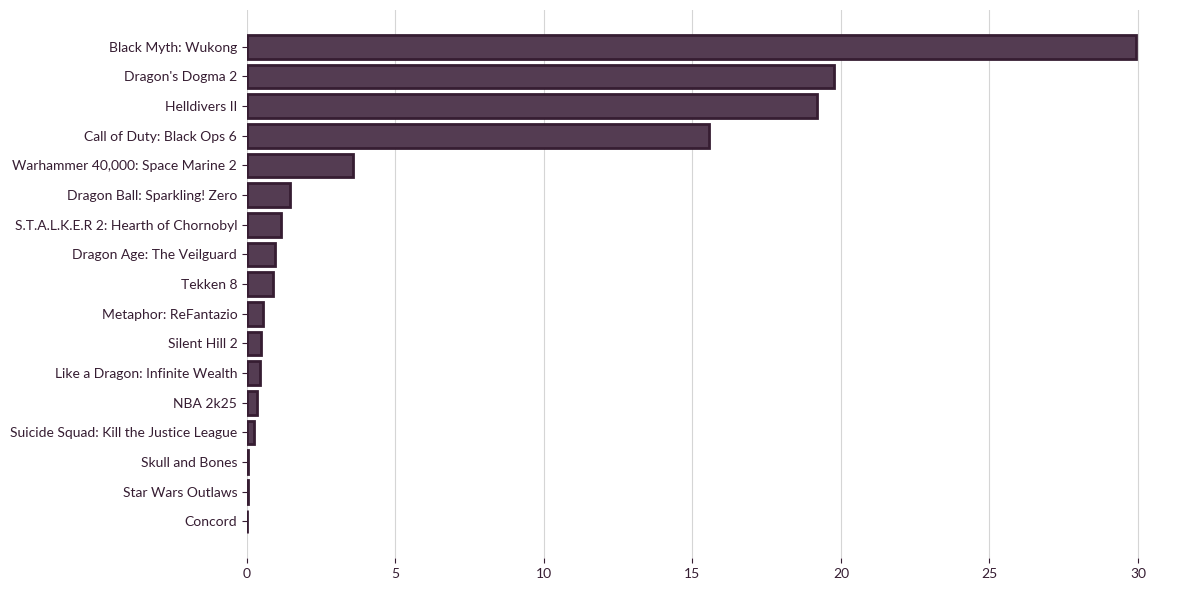

In [17]:
sales_aaa = sales_aaa.sort_values(by=['sales_k'])

fig, ax = plt.subplots(figsize=(12, 6))
for spine in plt.gca().spines.values(): spine.set_visible(False)

bars = plt.barh(sales_aaa['name'], sales_aaa['sales_k']/1000, color='#543C52', linewidth=2, edgecolor='#361D32')

# ax.set_xlim(0, 5000)

rect = ax.patch
rect.set_alpha(0)

plt.tight_layout()
ax.set_axisbelow(True)
ax.tick_params(axis='x', colors='#361D32')
ax.tick_params(axis='y', colors='#361D32')
ax.xaxis.grid(color='#d5d5d5')

plt.savefig(build_chart_path("sales_aaa_2024"), format="svg")

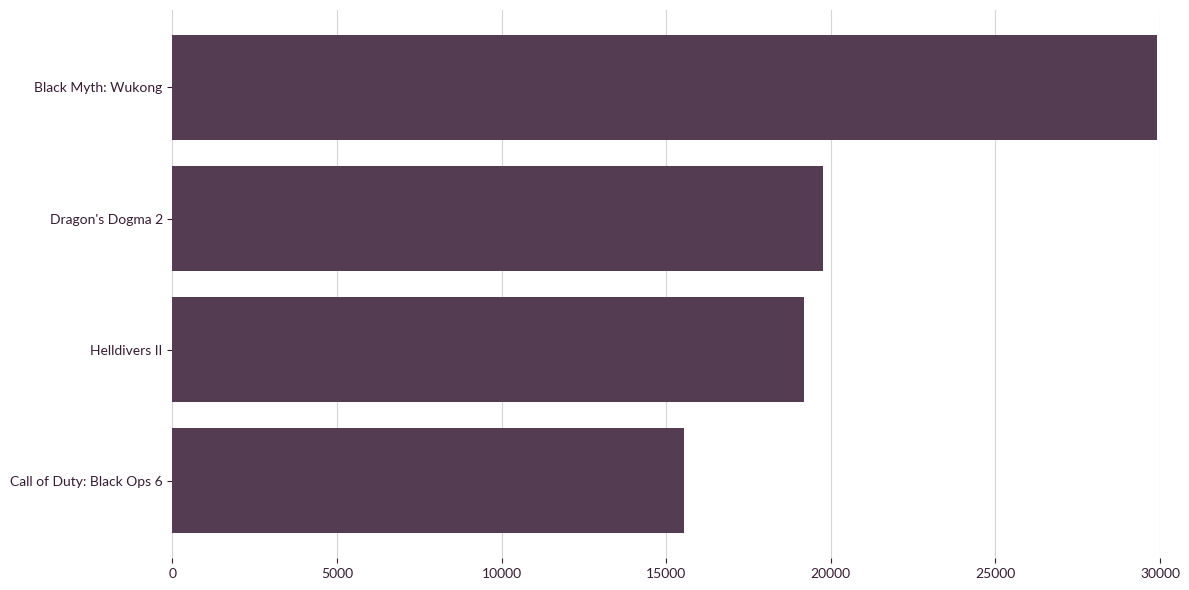

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))
for spine in plt.gca().spines.values(): spine.set_visible(False)

plt.barh(sales_aaa['name'].tail(4), sales_aaa['sales_k'].tail(4), color='#543C52', height=0.8)
ax.set_xlim(0, 30000)

rect = ax.patch
rect.set_alpha(0)
plt.tight_layout()
ax.set_axisbelow(True)
ax.tick_params(axis='x', colors='#361D32')
ax.tick_params(axis='y', colors='#361D32')
ax.xaxis.grid(color='#d5d5d5')


plt.savefig(build_chart_path("zoomed_sales_aaa_2024"), format="svg")

#### Note:
aggiungere a mano un + dopo il 5000 della scala;
segnare a mano le vendite degli ultimi 3: 35, 28, 16
marcare i primi 4 di colore diverso per far capire che superano la scala

##### Problema:
in entrambi i grafici è difficile contare il numero di vendite.
##### Suggerimento:
aggiungere linee verticali sugli assi

## Vendite giochi per continente di origine

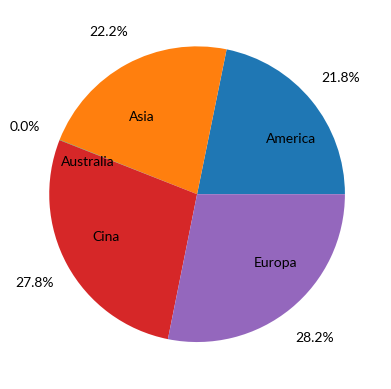

In [15]:
games_to_compare = games.query('comparing_with_concord != 1')
agg_by_continent = games_to_compare.groupby(['from_where'])['sales_k'].sum().to_frame().reset_index()

fig, ax = plt.subplots()

ax.pie(
    agg_by_continent['sales_k'],
    labels=agg_by_continent['from_where'],
    autopct='%1.1f%%',
    pctdistance=1.25,
    labeldistance=.6,
    radius=1
)

plt.savefig(build_chart_path("sales_by_continent_2024"), format="svg")

#### Note

Australia è presente, ma la label verrà rimossa nell'SVG. Possiamo mettere una nota a margine

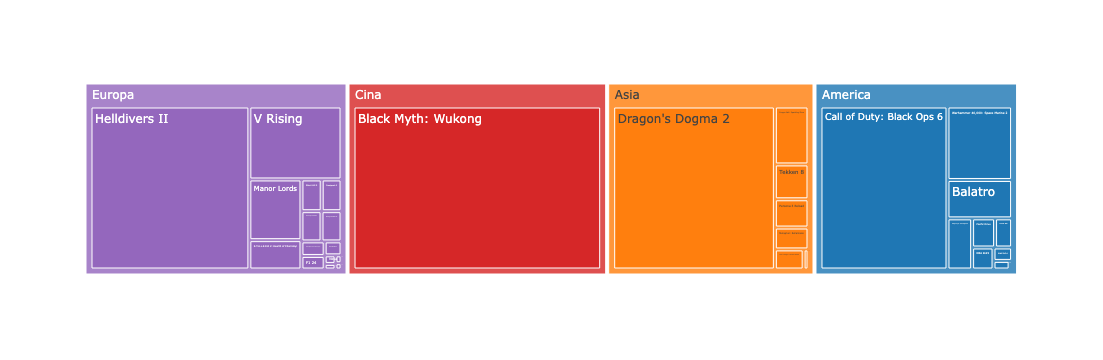

In [19]:
fig = px.treemap(games_to_compare, hover_name='name', path=['from_where','name'], values='sales_k',
                color_discrete_sequence=["#9467bd", "#d62728", "#ff7f0e", "#1f77b4"])

fig.show()
fig.write_image(build_chart_path("treemap_sales_by_continent"))

## Vendite in relazione alle recensioni

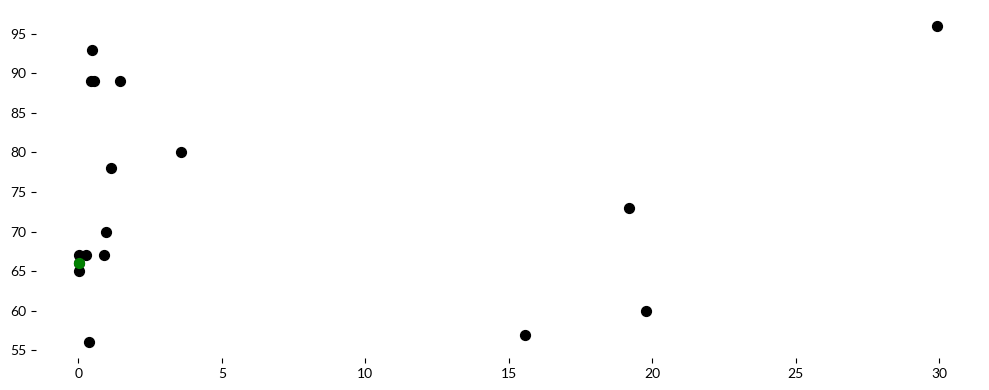

In [48]:
import matplotlib.pyplot as plt


games_to_compare = sales_aaa_aa.query('comparing_with_concord != 1')
concord = sales_aaa.query('name=="Concord"')

fig, ax = plt.subplots(figsize=(10, 4))
for spine in plt.gca().spines.values(): spine.set_visible(False)

plt.scatter(sales_aaa['sales_k']/1000, sales_aaa['reviews'], color='black', marker='o', s=50)
plt.scatter(concord['sales_k']/1000, concord['reviews'], color='green', marker='o', s=50)

plt.tight_layout()
ax.set_axisbelow(True)
plt.savefig(build_chart_path("sales_and_reviews_2024"), format="svg")

## Giochi Steam approvati in Cina

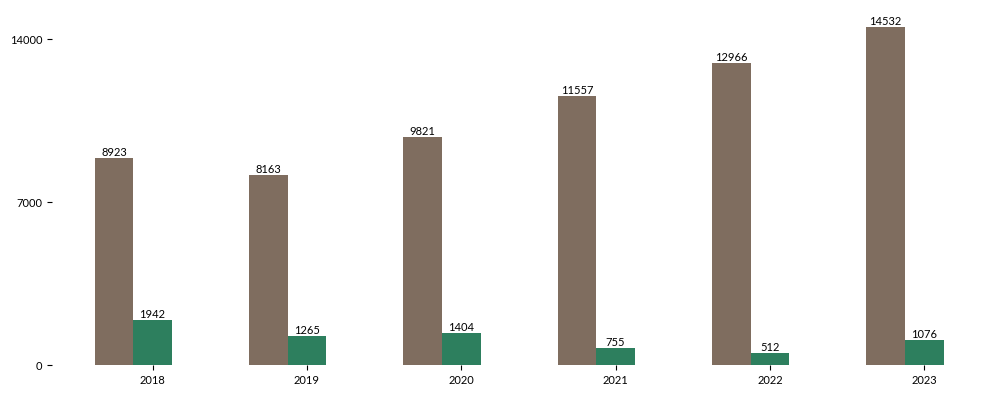

In [151]:
import numpy as np

games_in_china = pd.DataFrame(
    index=list(range(2018, 2024)),
    data={
    'global_releases_steam': [8923, 8163, 9821, 11557, 12966, 14532],
    'domestic_games_approved': [1892, 1085, 1307, 679, 468, 0],
    'games_approved': [50, 180, 97, 76, 44, 1076]
    }
)

# Merging data about local games and non-local games in China that are approved
games_in_china['games_approved'] =  games_in_china.iloc[:, 1:3].sum(axis=1)

barWidth = 0.25

r = np.arange(len(games_in_china.index))
r2 = r + barWidth

fig, ax = plt.subplots(figsize=(10, 4))
for spine in plt.gca().spines.values(): spine.set_visible(False)

bars1= ax.bar(r, games_in_china['global_releases_steam'], color='#7f6d5f', width=barWidth, label='Rilasci globali su Steam')
bars2= ax.bar(r2, games_in_china['games_approved'], color='#2d7f5e', width=barWidth, label='Videogiochi approvati in Cina')

# Xticks
ax.set_xticks(r + barWidth)
ax.set_xticklabels(games_in_china.index)
ax.set_yticks(list(range(0, 15000, 7000)))

for bar_group in [bars1, bars2]:
    for bar in bar_group:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height}',
            ha='center', va='bottom',
            fontsize=8
        )

rect = ax.patch
rect.set_alpha(0)

plt.tight_layout()
# ax.legend()

plt.savefig(build_chart_path("games_approved_china_yearly"), format="svg")

#### Note

Rimuovere scala sull'asse delle y. Abbiamo già i numeri sulle colonne

## Oscillazione recensioni nei primi quattro mesi

In [49]:
path = os.getcwd()
csv_files = glob.glob(os.path.join(path, "data/reviews/*.csv"))

games_reviews = {}

for f in csv_files:
    df = pd.read_csv(f, sep=";").head(120)

    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['Rating'] = df["Rating"].str.replace(',', '.').astype(float)
    df['Rating'] = df['Rating'].round(2)

    filename = (f.split("/")[-1]).split(".csv")[0]

    games_reviews[filename.split("_")[0]] = df

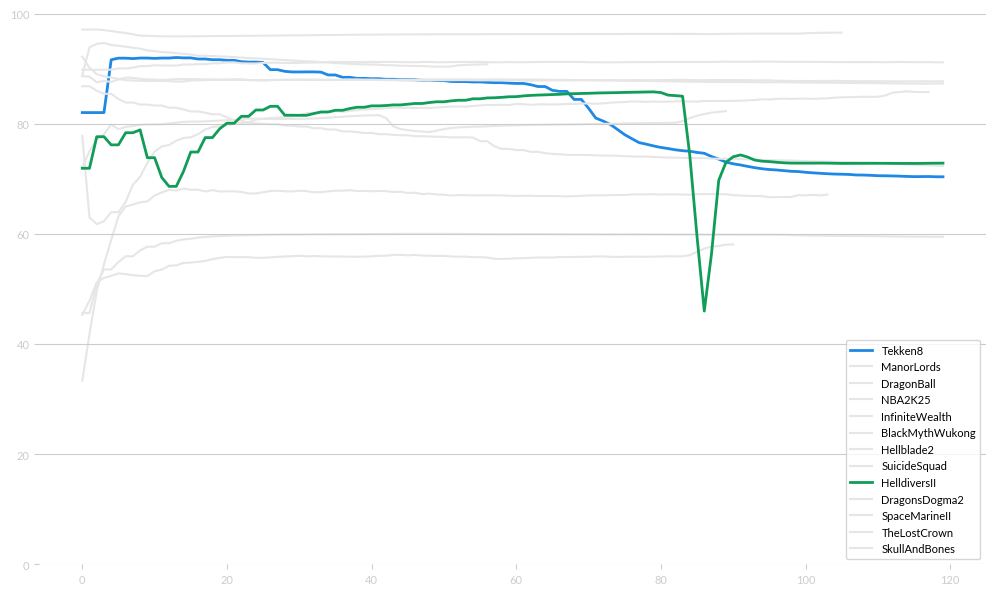

In [147]:
fig, ax = plt.subplots(figsize=(10,6))
for spine in plt.gca().spines.values(): spine.set_visible(False)

for game in games_reviews:
    df = games_reviews[game]

    if game == "HelldiversII":
        ax.plot(df.index, df['Rating'], label=game, color="#0F9D58", linewidth=2, zorder=1)
    elif game == "Tekken8":
        ax.plot(df.index, df['Rating'], label=game, color="#1E88E5", linewidth=2, zorder=0)
    else:
        ax.plot(df.index, df['Rating'], label=game, color="#E6E6E6", zorder=0)

rect = ax.patch
rect.set_alpha(0)


ax.set_ylim(0, 100)
ax.legend()
plt.tight_layout()
ax.set_axisbelow(True)
ax.tick_params(colors='#cccccc')
ax.yaxis.grid(color='#cccccc')

plt.savefig(build_chart_path("fluctuations_reviews_helldivers"), format="svg")

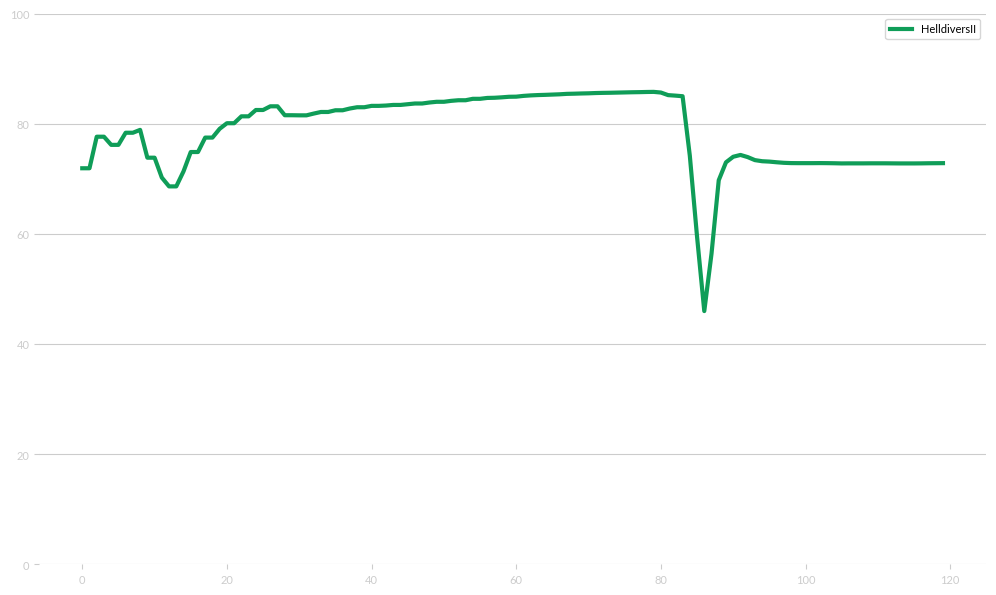

In [146]:
fig, ax = plt.subplots(figsize=(10,6))
for spine in plt.gca().spines.values(): spine.set_visible(False)

for game in games_reviews:
    df = games_reviews[game]

    if game == "HelldiversII":
        ax.plot(df.index, df['Rating'], label=game, color="#0F9D58", linewidth=3, zorder=1)

rect = ax.patch
rect.set_alpha(0)

ax.set_ylim(0, 100)

ax.legend()
plt.tight_layout()
ax.set_axisbelow(True)
ax.tick_params(colors='#cccccc')
ax.yaxis.grid(color='#cccccc')

plt.savefig(build_chart_path("fluctuations_reviews_helldivers_only"), format="svg")

## Metacritic vs Usercritic

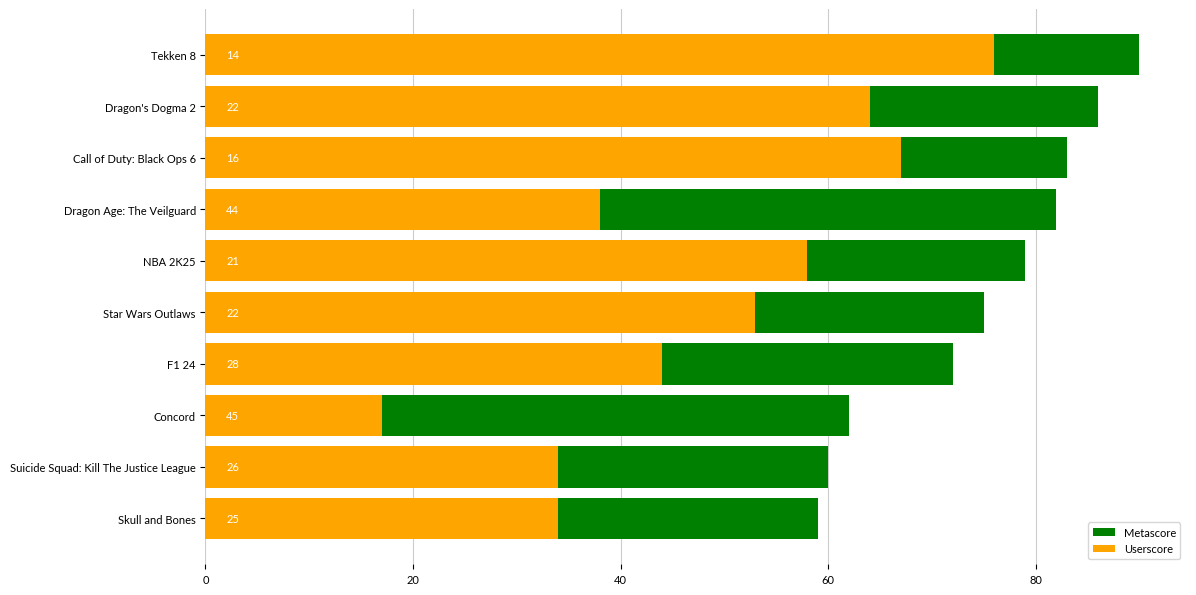

In [152]:
df = pd.DataFrame(
    columns = ['name', 'metascore', 'userscore'],
    data = {
        'name':['Concord', 'Suicide Squad: Kill The Justice League', 'Skull and Bones',
          'Star Wars Outlaws', 'Call of Duty: Black Ops 6', 'Tekken 8',
          "Dragon's Dogma 2", 'Dragon Age: The Veilguard', 'NBA 2K25', "F1 24"],
        'metascore': [62, 60, 59, 75, 83, 90, 86, 82, 79, 72],
        'userscore': [17, 34, 34, 53, 67, 76, 64, 38, 58, 44]
    }
)

df = df.sort_values(by=["metascore", "userscore"]).reset_index(drop=True)
df['difference'] = df['metascore'] - df['userscore']

fig, ax = plt.subplots(figsize=(12, 6))
for spine in plt.gca().spines.values(): spine.set_visible(False)

bar_meta = ax.barh(df['name'], df['metascore'], label='Metascore', color='green')
bar_user = ax.barh(df['name'], df['userscore'], label='Userscore', color='orange')

for index, bar in enumerate(bar_meta):
    x = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2

    ax.text(2, y, f'{df['difference'][index]}', va='center', ha='left', color='white', fontweight="bold")

rect = ax.patch
rect.set_alpha(0)

ax.legend()
plt.tight_layout()
ax.set_axisbelow(True)
ax.xaxis.grid(color='#cccccc')

plt.savefig(build_chart_path("metacritic_usercritic"), format="svg")

## Top mobile games 2024

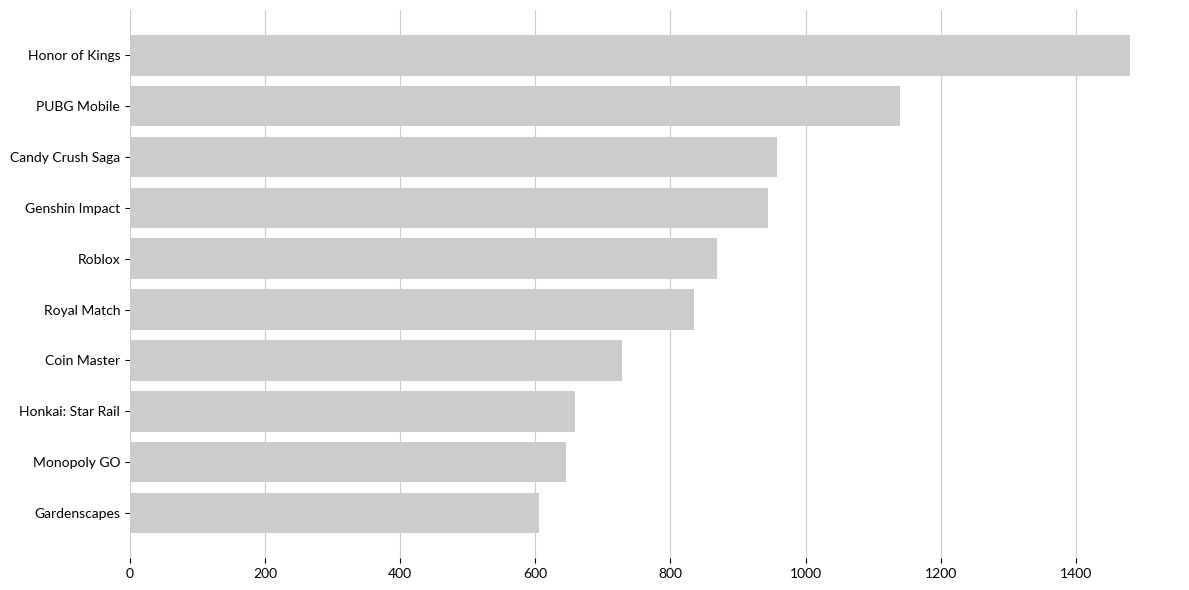

In [19]:
df = pd.DataFrame(
    columns = ["name", "revenue"],
    data = {
        "name": ['Honor of Kings', 'PUBG Mobile', 'Candy Crush Saga', 'Genshin Impact', 'Roblox', 'Royal Match', 'Coin Master', 
         'Honkai: Star Rail', 'Monopoly GO', 'Gardenscapes'],
        "revenue": [1480, 1140, 957, 944, 869, 835, 729, 659, 645, 606]
    }
)

df = df.sort_values(by=["revenue"])

fig, ax = plt.subplots(figsize=(12, 6))

ax.barh(df['name'], df['revenue'], color='#ccc')
for spine in plt.gca().spines.values(): spine.set_visible(False)

# plt.title('Top 10 giochi mobile del 2023 per incassi')
# plt.xlabel('dollars of revenue (in millions)')
# plt.ylabel('')

plt.tight_layout()
ax.set_axisbelow(True)
ax.xaxis.grid(color='#cccccc')


plt.savefig(build_chart_path("top_mobile_games_2024"), format="svg")

## Active Players

In [57]:
import matplotlib.dates as mdates

path = os.getcwd()
csv_files = glob.glob(os.path.join(path, "data/active_players/*.csv"))

active_players = pd.DataFrame()

for f in csv_files:
    filename = (f.split("/")[-1]).split(".csv")[0]
    game = filename.split("_")[1]
    
    df = pd.read_csv(f, sep=";")
    
    df = df.fillna(0)
    df['Players'] = pd.to_numeric(df['Players'])
    df['DateTime'] = pd.to_datetime(df['DateTime']).dt.date
    df['DateTime'] = mdates.date2num(df['DateTime'])

    # i'm removing all the entries before august
    # df = df.drop(df[df['epoch'] < 1724112000].index)

    df['Players'] = df['Players']

    df_grouped = df#.groupby(['DateTime'])['Players'].sum().reset_index()
    df_grouped['game'] = game

    active_players = pd.concat([active_players, df_grouped], ignore_index=True)

active_players

,DateTime,Players,game
0,20048.0,396.0,Strinova
1,20049.0,9525.0,Strinova
2,20049.0,13406.0,Strinova
3,20049.0,15039.0,Strinova
4,20049.0,15662.0,Strinova
...,...,...,...
6222,20063.0,0.0,Concord
6223,20063.0,0.0,Concord
6224,20063.0,0.0,Concord
6225,20063.0,0.0,Concord


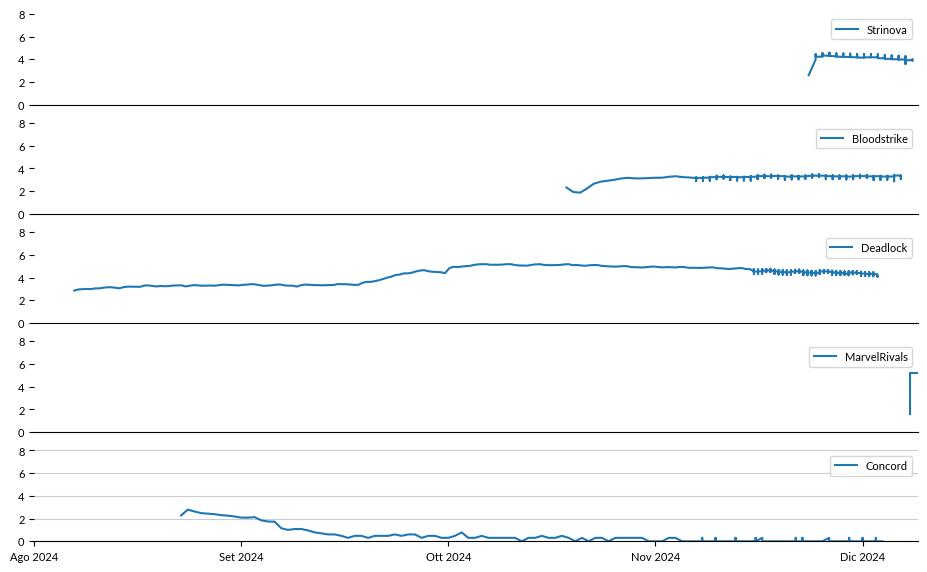

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, date, timedelta
import locale
locale.setlocale(locale.LC_TIME, "it_IT")

active_players['scaled_players'] = np.log10(active_players['Players'] + 1)
games = list(active_players['game'].unique())

plt.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(len(games), figsize=(11.4, 6.85))

x_ticks = np.arange(date(2024,8,1), datetime.today(), timedelta(days=31)).astype(datetime)

ath_players = {}

for i, game in enumerate(games):
    selected_game = active_players.query(f'game == "{game}"')

    ath_players[game] = selected_game.loc[selected_game['Players'].idxmax()]

    ax[i].plot(selected_game['DateTime'], selected_game['scaled_players'], label=game)
    ax[i].set_xticks(x_ticks)
    ax[i].set_ylim(0,8)

    rect = ax[i].patch
    rect.set_alpha(0)

    if i == len(games)-1:
        new_dates = [mdates.num2date(x).strftime('%b %Y') for x in ax[i].get_xticks()]
        ax[i].set_xticklabels(new_dates)
        ax[i].yaxis.grid(color='#cccccc')
    else:
        ax[i].set_xticks([])

    ax[i].legend()

    spines = ["top","right","left"]
    for s in spines:
        ax[i].spines[s].set_visible(False)


# plt.show()
plt.savefig(build_chart_path("active_players_pvp_logscaled"), format="svg")

In [59]:
ath_df = pd.DataFrame.from_dict(ath_players, orient='index',
                       columns=['DateTime', 'Players', 'game', 'scaled_players', 'relative_change'])
ath_df = ath_df.drop(columns=['game', 'scaled_players', 'relative_change'])

ath_df['DateTime'] = ath_df['DateTime'].apply(lambda x: mdates.num2date(x).strftime('%d %B %Y'))

ath_df

,DateTime,Players
Strinova,24 Novembre 2024,38043.0
Bloodstrike,24 Novembre 2024,3136.0
Deadlock,01 Settembre 2024,150000.0
MarvelRivals,06 Dicembre 2024,150000.0
Concord,24 Agosto 2024,607.0
